# CZ and LG (with SCH convex hull) for the P0 two-scenario case — Pyomo + (Gurobi if available)

This notebook reproduces paper-style figures (top row: scenario 1 & 2, bottom: total):

- **CZ** relaxation (constant underestimator per scenario on a fixed interval \(Y=[0,3]\)).
- **LG + SCH** relaxation using the convex hull (biconjugate) \(v^{**}_{\omega,Y}\) and LG supporting lines.

Implementation notes:
- We use **Pyomo** to compute a **discrete lower convex envelope** (SCH) via an LP with convexity constraints.
- If **Gurobi** is available, we solve with it; otherwise we fall back to any available LP solver.
- The underlying value functions \(v_1, v_2\) are the cubics from Appendix C (P0-V).


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pyomo.environ as pyo

# --------------------------
# Paper-like plot styling
# --------------------------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.0,
})

Y_L, Y_U = 0.0, 3.0

# Grid for convex-envelope LP & plotting (include 2.375 exactly)
h = 0.001
ys = np.arange(Y_L, Y_U + 1e-12, h)   # 0,0.001,...,3.000
N = len(ys)
print("Grid points:", N, " step=", h)

def pick_solver():
    # Prefer Gurobi (user request). Fall back gracefully if unavailable.
    for name in ["gurobi", "gurobi_direct", "gurobi_persistent", "cbc", "glpk", "highs"]:
        try:
            opt = pyo.SolverFactory(name)
            if opt is not None and opt.available(exception_flag=False):
                print("Using solver:", name)
                return opt, name
        except Exception:
            continue
    raise RuntimeError("No LP/MIP solver found. Install Gurobi (recommended) or GLPK/CBC/HiGHS.")

opt, solver_name = pick_solver()

# --- LaTeX rendering for legends (match style with previous notebooks) ---
# Requires a working LaTeX installation (TeX Live/MiKTeX) on your system.
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


Grid points: 3001  step= 0.001
Using solver: gurobi


In [18]:
# --------------------------
# P0 value functions (Appendix C, P0-V)
# --------------------------
def v1(y):
    y = np.asarray(y)
    return 1.00694*y**3 - 4.74589*y**2 + 5.17523*y

def v2(y):
    y = np.asarray(y)
    return -0.677232*y**3 + 3.03949*y**2 - 3.02338*y

def v(y):
    return v1(y) + v2(y)

f1 = v1(ys)
f2 = v2(ys)
fv = f1 + f2

# Exact 1D minimizers on [0,3] (for CZ constants): derivative roots + endpoints
def poly_min_on_interval(coef, a, b):
    dcoef = np.polyder(coef)
    roots = np.roots(dcoef)
    cand = [a, b]
    for r in roots:
        if abs(r.imag) < 1e-10:
            rr = float(r.real)
            if a <= rr <= b:
                cand.append(rr)
    cand = np.array(cand, dtype=float)
    vals = np.polyval(coef, cand)
    i = int(np.argmin(vals))
    return float(cand[i]), float(vals[i])

coef_v1 = np.array([1.00694, -4.74589, 5.17523, 0.0])
coef_v2 = np.array([-0.677232, 3.03949, -3.02338, 0.0])
coef_v  = coef_v1 + coef_v2

y1_star, v1_min = poly_min_on_interval(coef_v1, Y_L, Y_U)
y2_star, v2_min = poly_min_on_interval(coef_v2, Y_L, Y_U)
y_star,  v_min  = poly_min_on_interval(coef_v,  Y_L, Y_U)

print("y1* =", y1_star, "v1(y1*) =", v1_min)
print("y2* =", y2_star, "v2(y2*) =", v2_min)
print("y*  =", y_star,  "v(y*)  =", v_min)


y1* = 2.4399922374158347 v1(y1*) = -0.9999696231981718
y2* = 0.6300007793031237 v2(y2*) = -0.8676956489050687
y*  = 2.619967920966682 v(y*)  = -0.14585646148681


In [19]:
# --------------------------
# CZ relaxation on Y: constant = min_{y in Y} v_omega(y)
# --------------------------
v1_CZ = v1_min
v2_CZ = v2_min
v_CZ  = v1_CZ + v2_CZ

print("CZ constants:")
print("  v1_CZ =", v1_CZ)
print("  v2_CZ =", v2_CZ)
print("  v_CZ  =", v_CZ)


CZ constants:
  v1_CZ = -0.9999696231981718
  v2_CZ = -0.8676956489050687
  v_CZ  = -1.8676652721032405


In [20]:
# --------------------------
# SCH convex hull (lower convex envelope) via Pyomo LP
#   Variables h_i approximating v**(y_i)
#   Constraints:
#       h_i <= f_i   (underestimator)
#       slopes nondecreasing (convexity)
#   Objective:
#       maximize discrete trapezoid integral of h (push as high as possible while convex & <= f)
# --------------------------
def lower_convex_envelope_lp(ygrid, fvals, solver):
    n = len(ygrid)
    m = pyo.ConcreteModel()
    m.I = pyo.RangeSet(0, n-1)
    m.h = pyo.Var(m.I)

    def under_rule(mm, i):
        return mm.h[i] <= float(fvals[i])
    m.under = pyo.Constraint(m.I, rule=under_rule)

    def convex_rule(mm, i):
        if i == 0 or i == n-1:
            return pyo.Constraint.Skip
        dyL = float(ygrid[i] - ygrid[i-1])
        dyR = float(ygrid[i+1] - ygrid[i])
        # (h[i]-h[i-1])/(dyL) <= (h[i+1]-h[i])/(dyR)
        return (mm.h[i] - mm.h[i-1]) * dyR <= (mm.h[i+1] - mm.h[i]) * dyL
    m.convex = pyo.Constraint(m.I, rule=convex_rule)

    w = np.ones(n, dtype=float)
    w[0] = 0.5
    w[-1] = 0.5
    m.obj = pyo.Objective(expr=sum(float(w[i]) * m.h[i] for i in range(n)), sense=pyo.maximize)

    solver.solve(m, tee=False)
    return np.array([pyo.value(m.h[i]) for i in range(n)], dtype=float)

h1 = lower_convex_envelope_lp(ys, f1, opt)
h2 = lower_convex_envelope_lp(ys, f2, opt)
hSCH = h1 + h2

print("Convex envelopes computed (LP).")


Convex envelopes computed (LP).


In [21]:
# --------------------------
# y† = argmin_{y in Y} (h1+h2) on the grid
# --------------------------
idx_dag = int(np.argmin(hSCH))
y_dag = float(ys[idx_dag])
h1_dag = float(h1[idx_dag])
h2_dag = float(h2[idx_dag])
hSCH_dag = float(hSCH[idx_dag])

print("y† =", y_dag)
print("hSCH(y†) =", hSCH_dag)


y† = 2.365
hSCH(y†) = -1.223705536894315


In [22]:
# --------------------------
# LG supporting lines at y† with opposite slopes (LP), maximize slope s
#   line1(y) =  s*y + b1,  line1(y†)=h1(y†)
#   line2(y) = -s*y + b2,  line2(y†)=h2(y†)
# enforce line_omega(y_i) <= h_omega(y_i) for all grid points i.
# --------------------------
m = pyo.ConcreteModel()
m.s = pyo.Var(domain=pyo.Reals)
m.I = pyo.RangeSet(0, N-1)

def c1_rule(mm, i):
    return mm.s*ys[i] + (h1_dag - mm.s*y_dag) <= float(h1[i])
m.c1 = pyo.Constraint(m.I, rule=c1_rule)

def c2_rule(mm, i):
    return -mm.s*ys[i] + (h2_dag + mm.s*y_dag) <= float(h2[i])
m.c2 = pyo.Constraint(m.I, rule=c2_rule)

m.obj = pyo.Objective(expr=m.s, sense=pyo.maximize)
opt.solve(m, tee=False)

s_star = float(pyo.value(m.s))
b1 = h1_dag - s_star*y_dag
b2 = h2_dag + s_star*y_dag

print("LG slope s* =", s_star)
print("b1 =", b1, "b2 =", b2)

def v1_LG(y):
    y = np.asarray(y)
    return s_star*y + b1

def v2_LG(y):
    y = np.asarray(y)
    return -s_star*y + b2

def v_LG(y):
    return v1_LG(y) + v2_LG(y)


LG slope s* = -0.37492868043064304
b1 = -0.09892602978402876 b2 = -1.1247795071102862


In [23]:
# --------------------------
# Plotting (paper-like layout)
# --------------------------
def add_panel_label(ax, label):
    ax.text(0.5, -0.30, label, transform=ax.transAxes, ha="center", va="top", fontsize=13)

def make_figure_CZ(savepath=None):
    fig = plt.figure(figsize=(12.0, 7.2))
    gs = GridSpec(2, 2, height_ratios=[1.0, 1.05], hspace=0.55, wspace=0.65)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])

    ax1.plot(ys, f1, color="red", lw=2.0, label=r"$v_1$")
    ax1.plot(ys, v1_CZ*np.ones_like(ys), color="red", lw=2.0, ls=":", label=r"$v^{\mathrm{CZ}}_{1,Y}$")
    ax1.scatter([y1_star], [v1_CZ], color="black", s=22, zorder=5)
    ax1.text(y1_star-0.15, v1_CZ+0.05, r"$y_1^*$", fontsize=12)
    ax1.set_xlabel(r"$y$")
    ax1.set_ylabel(r"$v_1(y)$")
    ax1.set_xlim(Y_L, Y_U)
    ax1.set_ylim(-1.2, 2.0)
    ax1.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='lightgray', facecolor='white', framealpha=1.0)
    add_panel_label(ax1, r"(a)")

    ax2.plot(ys, f2, color="deepskyblue", lw=2.0, label=r"$v_2$")
    ax2.plot(ys, v2_CZ*np.ones_like(ys), color="deepskyblue", lw=2.0, ls=":", label=r"$v^{\mathrm{CZ}}_{2,Y}$")
    ax2.scatter([y2_star], [v2_CZ], color="black", s=22, zorder=5)
    ax2.text(y2_star-0.15, v2_CZ+0.05, r"$y_2^*$", fontsize=12)
    ax2.set_xlabel(r"$y$")
    ax2.set_ylabel(r"$v_2(y)$")
    ax2.set_xlim(Y_L, Y_U)
    ax2.set_ylim(-1.2, 2.0)
    ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='lightgray', facecolor='white', framealpha=1.0)
    add_panel_label(ax2, r"(b)")

    #ax3.plot(ys, f1, color="red", lw=2.0, label=r"$v_1$")
    #ax3.plot(ys, f2, color="deepskyblue", lw=2.0, label=r"$v_2$")
    ax3.plot(ys, fv, color="black", lw=2.0, label=r"$v$")
    ax3.plot(ys, v_CZ*np.ones_like(ys), color="black", lw=2.0, ls=":", label=r"$v^{\mathrm{CZ}}_{Y}$")

    #ax3.scatter([y_star], [v_min], color="black", s=26, zorder=6)
    #ax3.text(y_star-0.08, v_min+0.10, r"$y^*$", fontsize=12)
    #ax3.annotate("", xy=(y_star, v_min), xytext=(y_star, v_CZ),
    #             arrowprops=dict(arrowstyle="<->", lw=1.5, color="black"))

    ax3.set_xlabel(r"$y$")
    ax3.set_ylabel(r"$v(y)$")
    ax3.set_xlim(Y_L, Y_U)
    ax3.set_ylim(-2.0, 2.0)
    ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='lightgray', facecolor='white', framealpha=1.0)
    add_panel_label(ax3, r"(c)")

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig

def make_figure_LG(savepath=None):
    fig = plt.figure(figsize=(12.0, 7.2))
    gs = GridSpec(2, 2, height_ratios=[1.0, 1.05], hspace=0.55, wspace=0.65)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])

    ax1.plot(ys, f1, color="red", lw=2.0, label=r"$v_1$")
    ax1.plot(ys, v1_LG(ys), color="red", lw=2.0, ls="--", label=r"$v^{\mathrm{LG}}_{1,Y}$")
    ax1.plot(ys, h1, color="black", lw=2.0, ls="-.", label=r"$v^{**}_{1,Y}$")
    ax1.scatter([y_dag], [h1_dag], color="black", s=24, zorder=6)
    ax1.text(y_dag-0.10, h1_dag+0.10, r"$y^\dagger$", fontsize=12)
    ax1.set_xlabel(r"$y$")
    ax1.set_ylabel(r"$v_1(y)$")
    ax1.set_xlim(Y_L, Y_U)
    ax1.set_ylim(-1.4, 2.0)
    ax1.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='lightgray', facecolor='white', framealpha=1.0)
    add_panel_label(ax1, r"(a)")

    ax2.plot(ys, f2, color="deepskyblue", lw=2.0, label=r"$v_2$")
    ax2.plot(ys, v2_LG(ys), color="deepskyblue", lw=2.0, ls="--", label=r"$v^{\mathrm{LG}}_{2,Y}$")
    ax2.plot(ys, h2, color="black", lw=2.0, ls="-.", label=r"$v^{**}_{2,Y}$")
    ax2.scatter([y_dag], [h2_dag], color="black", s=24, zorder=6)
    ax2.text(y_dag-0.10, h2_dag+0.10, r"$y^\dagger$", fontsize=12)
    ax2.set_xlabel(r"$y$")
    ax2.set_ylabel(r"$v_2(y)$")
    ax2.set_xlim(Y_L, Y_U)
    ax2.set_ylim(-1.4, 2.0)
    ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='lightgray', facecolor='white', framealpha=1.0)
    add_panel_label(ax2, r"(b)")

    #ax3.plot(ys, f1, color="red", lw=2.0, label=r"$v_1$")
    #ax3.plot(ys, f2, color="deepskyblue", lw=2.0, label=r"$v_2$")
    #ax3.plot(ys, v1_LG(ys), color="red", lw=2.0, ls="--", label=r"$v^{\mathrm{LG}}_{1,Y}$")
    #ax3.plot(ys, v2_LG(ys), color="deepskyblue", lw=2.0, ls="--", label=r"$v^{\mathrm{LG}}_{2,Y}$")
#     ax3.plot(ys, hSCH, color="black", lw=2.0, ls="-.", label=r"$v^{\mathrm{SCH}}_{Y}$")
    ax3.plot(ys, v_LG(ys), color="black", lw=2.0, ls="--", label=r"$v^{\mathrm{LG}}_{Y}$")
    ax3.plot(ys, fv, color="black", lw=2.0, label=r"$v$")

#     ax3.scatter([y_dag], [hSCH_dag], color="black", s=26, zorder=6)
#     ax3.text(y_dag-0.08, hSCH_dag+0.10, r"$y^\dagger$", fontsize=12)

    ax3.set_xlabel(r"$y$")
    ax3.set_ylabel(r"$v(y)$")
    ax3.set_xlim(Y_L, Y_U)
    ax3.set_ylim(-1.4, 1.8)
    ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, edgecolor='lightgray', facecolor='white', framealpha=1.0)
    add_panel_label(ax3, r"(c)")

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig

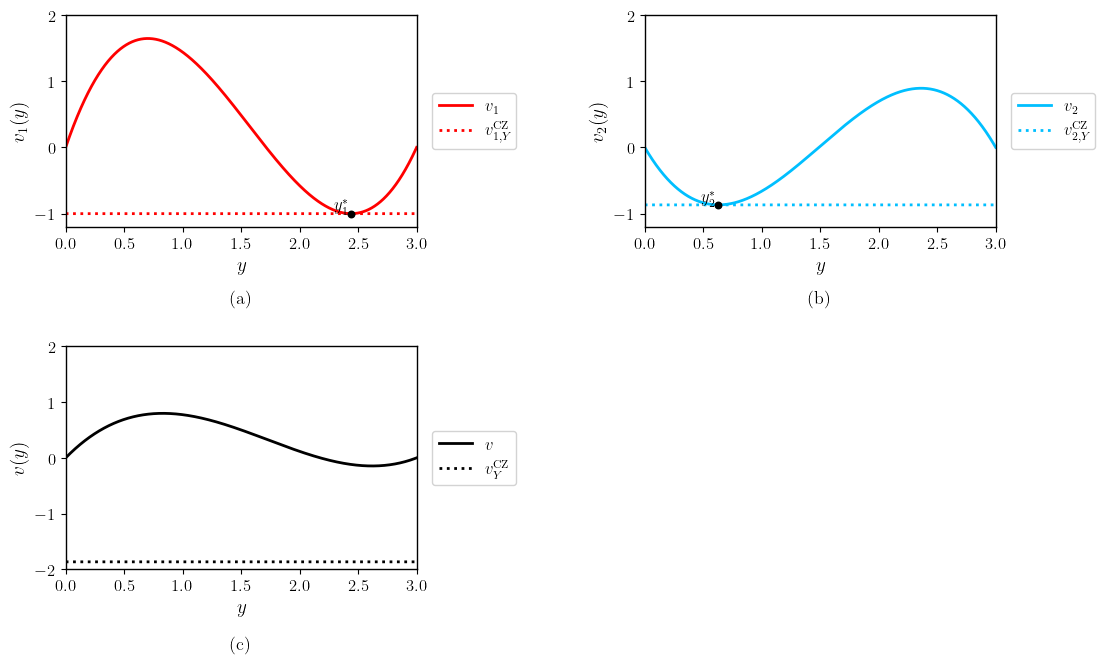

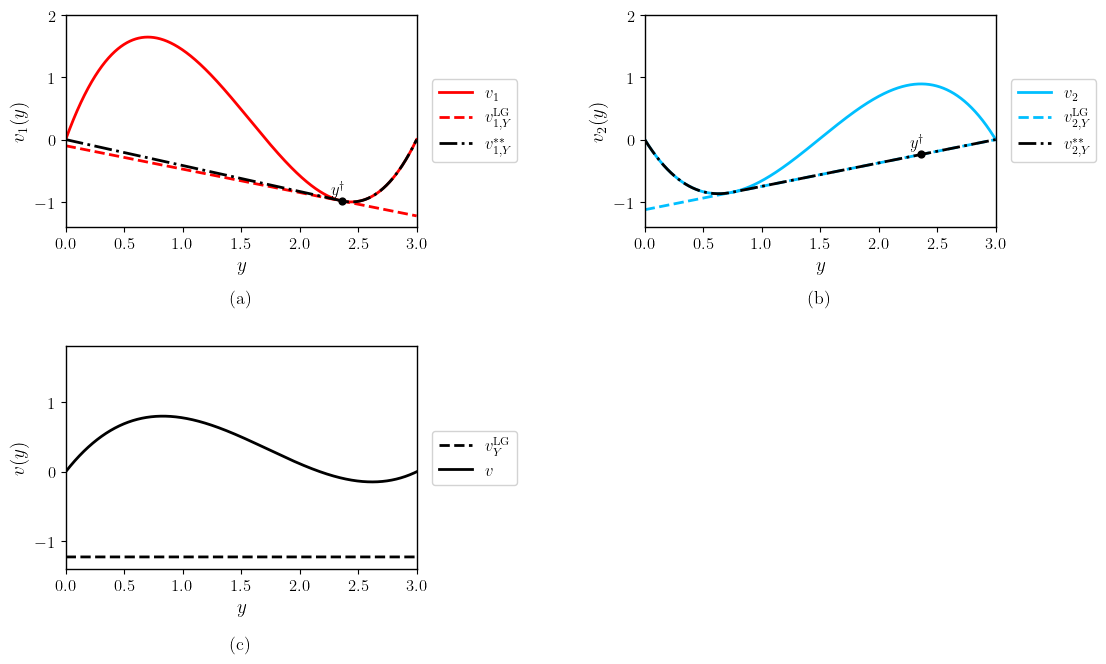

Saved figures:
  CZ_P0_pyomo.png
  LG_P0_pyomo.png


In [24]:
# --------------------------
# Generate figures (saved as PNG)
# --------------------------
fig_cz = make_figure_CZ(savepath="CZ_P0_pyomo.png")
plt.show()

fig_lg = make_figure_LG(savepath="LG_P0_pyomo.png")
plt.show()

print("Saved figures:")
print("  CZ_P0_pyomo.png")
print("  LG_P0_pyomo.png")
